<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Predicting House Sale Prices for Ames, Iowa

## Problem Statement

As a Data Scientist in ABC-XYZ Corp., create a model that can accurately recommend a house sale price for homeowners of Ames, Iowa looking to sell their property, given certain input variables on the house specifications by the homeowner.

### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Simple Model](#Simple-Model)
- [Pre-processing and Feature Engineering](#Pre-processing-and-Feature-Engineering)
- [Model Benchmarks and Tuning](#Model-Benchmarks-and-Tuning)
- [Production Model](#Production-Model)
- [Insights](#Insights)
- [Kaggle Submission Score](#Kaggle-Submission-Score)

## Background

Our fictional company, ABC-XYZ Corp., is a long standing giant in the real estate industry. The executives want to create a website that is able to accurately recommend an estimated sale price to budding sellers, given user inputs on the house specifications, as a way to entice sellers to work with the company's many real estate agents.

Acting as the recently recruited Data Scientist, I was tasked to first start of with building a model to accurately predict house sale prices in Ames, Iowa, ABC-XYZ Corp.'s HQ location.

Coming from a Singaporean background, I am aware of another similar company who has a working model that ABC-XYZ Corp. is looking for. A homeowner has to input certain variables such as postal code, property type, floor, unit no., and floor area (as pictured in **Input Variables** below), in order to get an estimate on the sale value (as pictured in **Estimate Sale Valuation** below).

After pitching the idea to the bosses at ABC-XYZ Corp., they are ecstatic and wishes to do the same for their website. However, they have requested to identify and include important localized variables.

Given the Ames Iowa Housing dataset, I will now start to choose those important localized variables and fit into a model to correctly predict future house sale prices.


### Input Variables

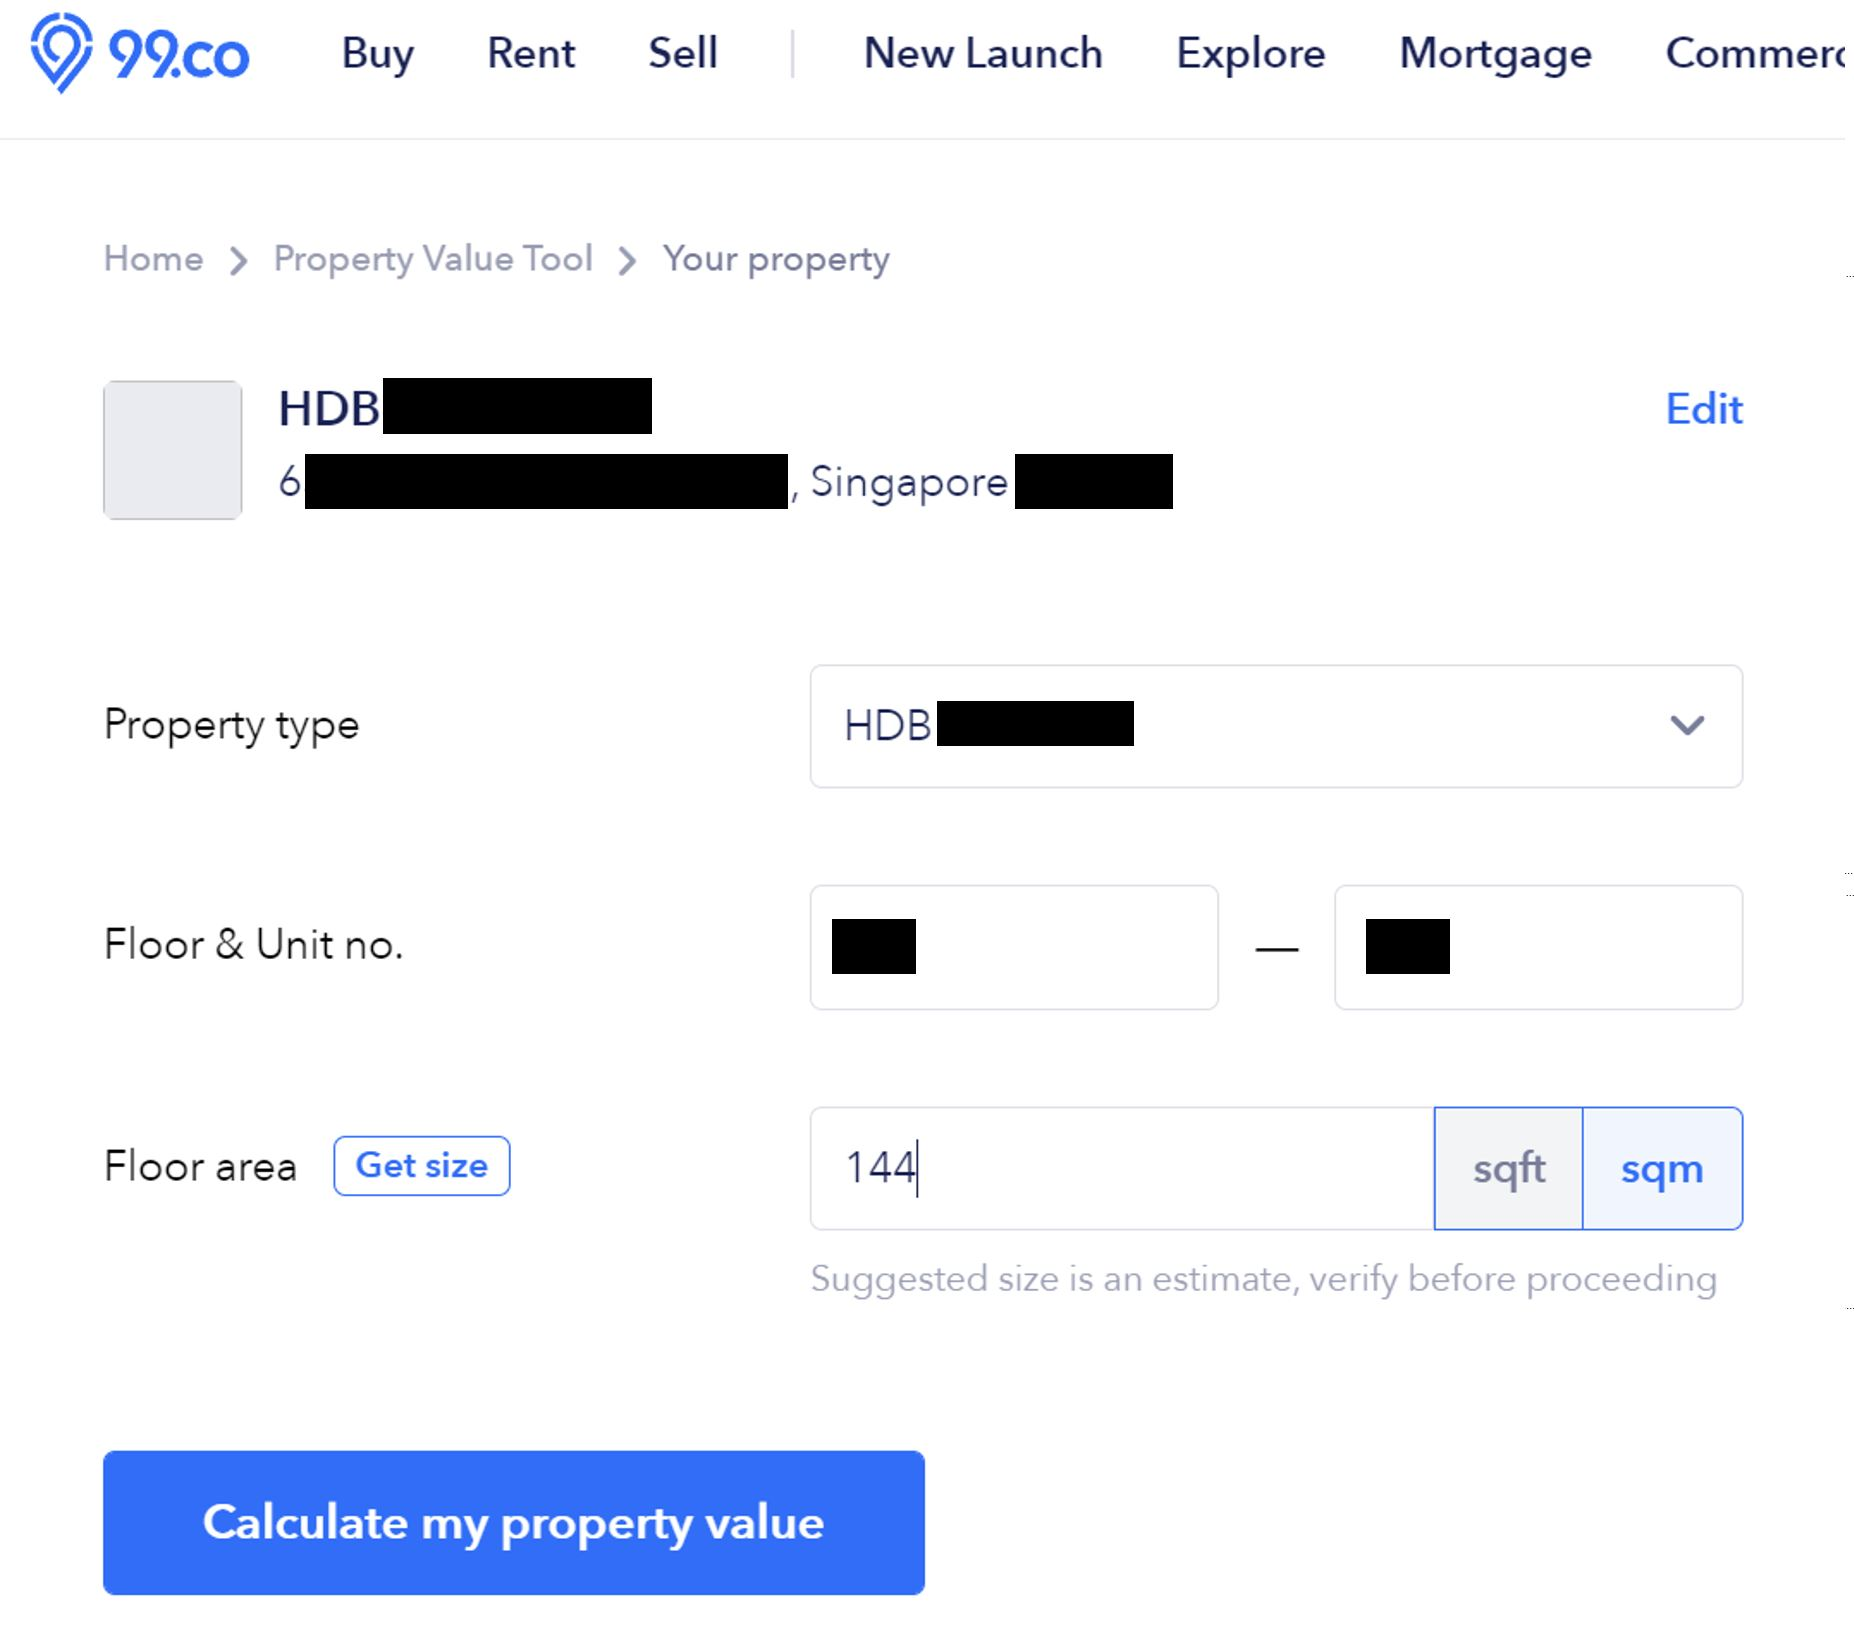


### Estimate Sale Valuation
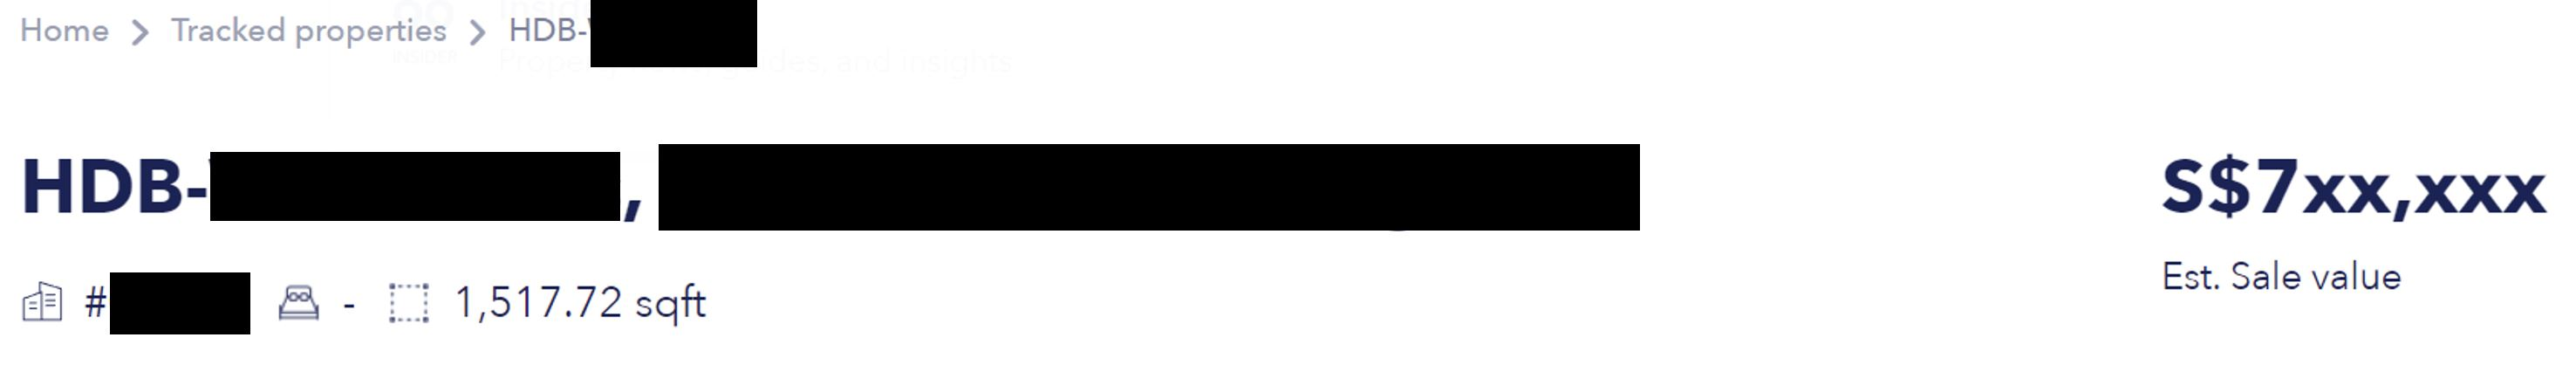


(source: 99.co, https://www.99.co/)

---

## Data Import & Cleaning

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('datasets/train.csv')
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace(' ', '_')

Data Dictionary: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

### Initial Feature Filtering



In [3]:
data.shape

(2051, 81)

The Ames Housing dataset has 81 columns. Tradeoffs were made in this regard to focus on the task at hand.

Some of the features overdescribes the house specifications. For example, 'garage_cars' and 'garage_area' specifies the same thing, albeit in slightly different ways. 'garage_area', containing continuous numerical values, is picked out of the two.

Another category of features describe a subset of another feature. For example, 'bsmtfin_sf_2','bsmtfin_sf_1', and 'bsmt_unf_sf', are subsets of 'total_bsmt_sf' and as such, 'total_bsmt_sf' is chosen out of all named. Exceptions were made for features that are on an ordinal scale as the weightage of certain specifications of the house might not be equal (i.e. Kitchen Quality might have different weightage when compared to Basement Quality with respect to Overall Quality)

Others that describe the house identification information (like 'id' and 'pid') or those that features describing miscellaneous features (with lesser data points) are not useful in a regression model and will not be chosen.

**Total IDs dropped:**

'id', 'pid', 'condition_1', 'condition_2', 'exterior_2nd', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'garage_yr_blt', 'garage_cars', 'mo_sold', 'yr_sold'.

In [4]:
#filtering for features of choice
data_choice = data.loc[:, [
    'lot_frontage', 'lot_area', 'mas_vnr_area', 
    'total_bsmt_sf', 'gr_liv_area', 'bsmt_full_bath',
    'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
    'kitchen_abvgr','totrms_abvgrd', 'fireplaces','garage_area',
    'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch',
    'screen_porch', 'pool_area','misc_val',
     'ms_subclass', 'ms_zoning', 'street', 'alley',
    'land_contour', 'lot_config', 'utilities',
    'bldg_type', 'house_style', 'roof_style',
    'roof_matl', 'exterior_1st', 'mas_vnr_type',
    'foundation', 'heating', 'central_air',
    'garage_type', 'misc_feature', 'sale_type',
    'lot_shape', 'land_slope', 'overall_qual', 'overall_cond',
    'exter_qual', 'exter_cond','bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'heating_qc',
    'electrical','kitchen_qual', 'functional', 'fireplace_qu',
    'garage_finish', 'garage_qual', 'neighborhood',
       'garage_cond', 'paved_drive',
    'pool_qc', 'fence', 'year_built', 'year_remod/add',
    'saleprice' 
]]

### Data Cleaning

**Cleaning Features of Year Built and Year Since Remodelled/Addition**

In [5]:
#Calculate the age of the house and years since last remodelling/addition and making a new column
data_choice['years_since_built'] = data_choice['year_built'].map(lambda x: 2020 - x)
data_choice['years_since_remod'] = data_choice['year_remod/add'].map(lambda x: 2020 - x)
data_choice.drop(columns = ['year_built', 'year_remod/add'], axis = 1, inplace=True)

**Cleaning Numerical Features**

In [6]:
#extracting numerical features for analysis
data_numerical = data.loc[:, [
    'lot_frontage', 'lot_area', 'mas_vnr_area', 
    'total_bsmt_sf', 'gr_liv_area', 'bsmt_full_bath',
    'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
    'kitchen_abvgr','totrms_abvgrd', 'fireplaces','garage_area',
    'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch',
    'screen_porch', 'pool_area','misc_val', 'saleprice'
]]

#checking for null values
data_numerical.isnull().sum()

lot_frontage      330
lot_area            0
mas_vnr_area       22
total_bsmt_sf       1
gr_liv_area         0
bsmt_full_bath      2
bsmt_half_bath      2
full_bath           0
half_bath           0
bedroom_abvgr       0
kitchen_abvgr       0
totrms_abvgrd       0
fireplaces          0
garage_area         1
wood_deck_sf        0
open_porch_sf       0
enclosed_porch      0
3ssn_porch          0
screen_porch        0
pool_area           0
misc_val            0
saleprice           0
dtype: int64

A) <u>Cleaning 'lot_frontage'</u>

Lot Frontage is the length of the side of the lot facing the street/public sidewalk (illustrated in red below). The type of house ('ms_subclass') and the lot configuration ('lot_config') should give an indication to what the value might be for those rows with NaN values.

For example, if the majority of houses are of 'ms_subclass' = 180 (PUD - MULTILEVEL - INCL SPLIT LEV/FOYER) would mean that the houses are apartment type without any lot frontage. In this scenario, we can set the NaN values as zero.

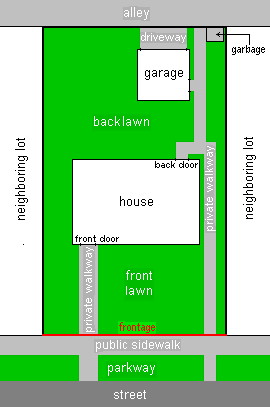

(from: https://upload.wikimedia.org/wikipedia/commons/b/bc/Lot_map.PNG)

In [7]:
#Zooming in on 'lot_frontage' null values
lot_f_nan = data_choice.loc[data_choice['lot_frontage'].isnull(), ['ms_subclass', 'lot_config']]

#Checking the 'ms_subclass' and 'lot_config' values for NaN rows
print("\033[4m'ms_subclass' values for 'lot_frontage' NaN rows\033[0m");
print(lot_f_nan['ms_subclass'].value_counts(dropna=False))
print()
print("\033[4m'lot_config' values for 'lot_frontage' NaN rows\033[0m");
print(lot_f_nan['lot_config'].value_counts(dropna=False))

'ms_subclass' values for 'lot_frontage' NaN rows
20     131
60      86
80      23
120     23
50      16
90      12
85      10
30       9
160      8
70       6
190      3
180      1
75       1
150      1
Name: ms_subclass, dtype: int64

'lot_config' values for 'lot_frontage' NaN rows
Inside     190
Corner      67
CulDSac     61
FR2         11
FR3          1
Name: lot_config, dtype: int64


From the 'ms_subclass' and 'lot_config' values above, we see that there isn't a clear overwhelming majority for one value for either features. Furthermore, there are cases of 'ms_subclass' = 20 (1-STORY 1946 & NEWER ALL STYLES) still having NaN values when we would expect it to have a numerical value instead. This leads to the theory that these values a Missing Completely At Random.

Thus, setting the values to the mean 'lot_frontage' value of each 'ms_subclass' for other rows would be better then setting them to zero or dropping the rows.

In [8]:
#Fixing 'lot_frontage' values in the main data_choice df.
fr_mean = data_choice.groupby('ms_subclass')['lot_frontage'].mean()

#Since 'ms_subclass' = 150 is a NaN value, set it to the same value of the closest 'ms_subclass'
fr_mean.loc[150] = fr_mean.loc[120]

#Retrieving indexes of 'lot_frontage' null value rows.
fr_index = data_choice[data_choice['lot_frontage'].isnull()].index

#Setting the value of NaN to the mean according to 'ms_subclass' value.
for index in fr_index:
    data_choice.loc[index, 'lot_frontage'] = fr_mean[data_choice.loc[index,'ms_subclass']]    

In [9]:
#double-checking
data_choice.loc[fr_index, ['ms_subclass','lot_frontage']]

,ms_subclass,lot_frontage
0,60,78.269481
7,20,77.032864
8,20,77.032864
23,20,77.032864
27,50,63.000000
...,...,...
2016,20,77.032864
2022,20,77.032864
2028,20,77.032864
2031,20,77.032864


B) <u>Cleaning 'mas_vnr_area'</u>

In [10]:
#Zooming in on 'mas_vnr_area' null values
vnr_nan = data_choice.loc[data['mas_vnr_area'].isnull(), ['mas_vnr_type']]

vnr_nan.isnull().sum()

mas_vnr_type    22
dtype: int64

Since all 'mas_vnr_area' null value rows also has null values in 'mas_vnr_type', we can assume that the houses do not have a veneer and set all to zero.

In [11]:
data_choice['mas_vnr_area'] = data_choice['mas_vnr_area'].map(lambda x: 0 if np.isnan(x) else x)
#double-checking
data_choice['mas_vnr_area'].isnull().sum()

0

C) <u>Cleaning Other Features with Null Values </u>

Since the remaining null values are of low quantity (maximum 6 out of 2051 rows), I will be dropping the rows.

In [12]:
#Retrieving indexes of remainder null value rows.
remnd_nan = ['total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath', 'garage_area']
num_nan_index = []

for feature in remnd_nan:
    num_nan_index += list(data_choice[data_choice[feature].isnull()].index)

In [13]:
#dropping the rows
data_choice.drop(num_nan_index, axis = 0, inplace=True)

In [14]:
#double-checking
data_choice[data_numerical.columns].isnull().sum()

lot_frontage      0
lot_area          0
mas_vnr_area      0
total_bsmt_sf     0
gr_liv_area       0
bsmt_full_bath    0
bsmt_half_bath    0
full_bath         0
half_bath         0
bedroom_abvgr     0
kitchen_abvgr     0
totrms_abvgrd     0
fireplaces        0
garage_area       0
wood_deck_sf      0
open_porch_sf     0
enclosed_porch    0
3ssn_porch        0
screen_porch      0
pool_area         0
misc_val          0
saleprice         0
dtype: int64

**Cleaning Ordinal Features**

In [15]:
#extracting ordinal features for analysis
data_ordinal = data.loc[:,[
    'lot_shape', 'land_slope', 'overall_qual', 'overall_cond',
    'exter_qual', 'exter_cond','bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'heating_qc',
    'electrical','kitchen_qual', 'functional', 'fireplace_qu',
    'garage_finish', 'garage_qual',
       'garage_cond', 'paved_drive',
    'pool_qc', 'fence', 'saleprice']         
]

#checking for null values

data_ordinal.isnull().sum()

lot_shape           0
land_slope          0
overall_qual        0
overall_cond        0
exter_qual          0
exter_cond          0
bsmt_qual          55
bsmt_cond          55
bsmt_exposure      58
heating_qc          0
electrical          0
kitchen_qual        0
functional          0
fireplace_qu     1000
garage_finish     114
garage_qual       114
garage_cond       114
paved_drive         0
pool_qc          2042
fence            1651
saleprice           0
dtype: int64

Since these features are on the Ordinal scale, I convert the scale to numerical values with null values = 0, and the worse starts from 1.

In [16]:
data_choice['fence'] = data_choice.loc[:, 'fence'].map(lambda x:                                                                  
                                                                 4 if x == 'GdPrv' else
                                                                 3 if x == 'MnPrv' else
                                                                 2 if x == 'GdWo' else
                                                                 1 if x == 'MnWw' else
                                                                 0
                                                                )

data_choice['paved_drive'] = data_choice.loc[:, 'paved_drive'].map(lambda x:                                                                  
                                                                 1 if x == 'Y' else
                                                                 1 if x == 'P' else
                                                                 0
                                                                )

data_choice['garage_finish'] = data_choice.loc[:, 'garage_finish'].map(lambda x:                                                                  
                                                                 3 if x == 'Fin' else
                                                                 2 if x == 'RFn' else
                                                                 1 if x == 'Unf' else
                                                                 0
                                                                )


data_choice['electrical'] = data_choice.loc[:, 'electrical'].map(lambda x: 
                                                                 4 if x == 'SBrkr' else
                                                                 3 if x == 'FuseA' else
                                                                 2 if x == 'FuseF' else
                                                                 1 if x == 'FuseP' else
                                                                 0
                                                                )

data_choice['bsmt_exposure'] = data_choice.loc[:, 'bsmt_exposure'].map(lambda x: 
                                                                 4 if x == 'Gd' else
                                                                 3 if x == 'Av' else
                                                                 2 if x == 'Mn' else
                                                                 1 if x == 'No' else
                                                                 0
                                                                )

data_choice['lot_shape'] = data_choice.loc[:, 'lot_shape'].map(lambda x: 
                                                                 4 if x == 'Reg' else
                                                                 3 if x == 'IR1' else
                                                                 2 if x == 'IR2' else
                                                                 1 if x == 'IR3' else
                                                                 0
                                                                )

data_choice['land_slope'] = data_choice.loc[:, 'land_slope'].map(lambda x: 
                                                                 3 if x == 'Gtl' else
                                                                 2 if x == 'Mod' else
                                                                 1 if x == 'Sev' else
                                                                 0
                                                                )

ord_feature = ['exter_qual', 'bsmt_qual', 'bsmt_cond', 'heating_qc',
               'kitchen_qual','fireplace_qu', 'garage_qual', 'garage_cond',
               'pool_qc', 'exter_cond'
              ]

for feature in ord_feature:
        data_choice[feature] = data_choice.loc[:, feature].map(lambda x: 
                                                                 5 if x == 'Ex' else 
                                                                 4 if x == 'Gd' else 
                                                                 3 if x == 'TA' else
                                                                 2 if x == 'Fa' else
                                                                 1 if x == 'Po' else
                                                                 0
                                                                )

data_choice['functional'] = data_choice.loc[:, 'functional'].map(lambda x: 
                                                                 8 if x == 'Typ' else 
                                                                 7 if x == 'Min1' else 
                                                                 6 if x == 'Min2' else
                                                                 5 if x == 'Mod' else
                                                                 4 if x == 'Maj1' else
                                                                 3 if x == 'Maj2' else
                                                                 2 if x == 'Sev' else
                                                                 1 if x == 'Sal' else
                                                                 0
                                                                )

In [17]:
#double checking
data_choice[data_ordinal.columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048 entries, 0 to 2050
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   lot_shape      2048 non-null   int64
 1   land_slope     2048 non-null   int64
 2   overall_qual   2048 non-null   int64
 3   overall_cond   2048 non-null   int64
 4   exter_qual     2048 non-null   int64
 5   exter_cond     2048 non-null   int64
 6   bsmt_qual      2048 non-null   int64
 7   bsmt_cond      2048 non-null   int64
 8   bsmt_exposure  2048 non-null   int64
 9   heating_qc     2048 non-null   int64
 10  electrical     2048 non-null   int64
 11  kitchen_qual   2048 non-null   int64
 12  functional     2048 non-null   int64
 13  fireplace_qu   2048 non-null   int64
 14  garage_finish  2048 non-null   int64
 15  garage_qual    2048 non-null   int64
 16  garage_cond    2048 non-null   int64
 17  paved_drive    2048 non-null   int64
 18  pool_qc        2048 non-null   int64
 19  fence 

**Cleaning Categorical Features**

The aim here is to dummify all categorical columns while taking note which dummy columns were dropped. this is to ensure that when the test set is transformed, we can check if the same dummy value was dropped.

In [18]:
#identifying nominal features
feature_nominal = [
    'ms_subclass', 'ms_zoning', 'street', 'alley',
    'land_contour', 'lot_config', 'utilities',
    'bldg_type', 'house_style', 'roof_style',
    'roof_matl', 'exterior_1st', 'mas_vnr_type',
    'foundation', 'heating', 'central_air',
    'garage_type', 'misc_feature', 'sale_type',
    'neighborhood'
]

In [19]:
def manual_dummies(DataFrame, feature_list):
    """Function accepts a DataFrame and a feature list to create dummies columns for the values within the features of the DataFrame."""
    """Returns the modified DataFrame and prints out the value that has been dropped."""
    for feature in feature_list:
        nominal_values = list(DataFrame[feature].value_counts().index)
        for value in nominal_values[:-1]:
            DataFrame[(str(feature) + '_' + str(value))] = DataFrame.loc[:, str(feature)].map(lambda x: 1 if x == value else 0)
        print(f"'{nominal_values[-1]}' was dropped from '{feature}'.")
        DataFrame.drop(columns = str(feature), axis = 1, inplace=True)
    return DataFrame.columns

In [20]:
manual_dummies(data_choice, feature_nominal)

'150' was dropped from 'ms_subclass'.
'I (all)' was dropped from 'ms_zoning'.
'Grvl' was dropped from 'street'.
'Pave' was dropped from 'alley'.
'Low' was dropped from 'land_contour'.
'FR3' was dropped from 'lot_config'.
'NoSewr' was dropped from 'utilities'.
'2fmCon' was dropped from 'bldg_type'.
'2.5Fin' was dropped from 'house_style'.
'Shed' was dropped from 'roof_style'.
'ClyTile' was dropped from 'roof_matl'.
'AsphShn' was dropped from 'exterior_1st'.
'BrkCmn' was dropped from 'mas_vnr_type'.
'Wood' was dropped from 'foundation'.
'OthW' was dropped from 'heating'.
'N' was dropped from 'central_air'.
'CarPort' was dropped from 'garage_type'.
'Elev' was dropped from 'misc_feature'.
'Oth' was dropped from 'sale_type'.
'Landmrk' was dropped from 'neighborhood'.


Index(['lot_frontage', 'lot_area', 'mas_vnr_area', 'total_bsmt_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr',
       ...
       'neighborhood_SWISU', 'neighborhood_ClearCr', 'neighborhood_MeadowV',
       'neighborhood_Blmngtn', 'neighborhood_BrDale', 'neighborhood_Veenker',
       'neighborhood_NPkVill', 'neighborhood_Blueste', 'neighborhood_Greens',
       'neighborhood_GrnHill'],
      dtype='object', length=168)

In [21]:
data_choice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048 entries, 0 to 2050
Columns: 168 entries, lot_frontage to neighborhood_GrnHill
dtypes: float64(6), int64(162)
memory usage: 2.6 MB


---

## Exploratory Data Analysis

At the current moment we have 163 features in our dataset. We need to deep dive into the following to see if we can eliminate non-correlated features before we can proceed to modelling.


#### Collinearity

Example: Correlation Heat Map of Years Since Built and Years Since Remodelled vs Sale Price

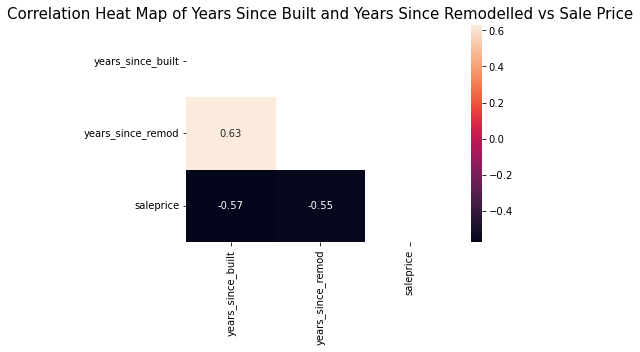

In [22]:
#Extracting relevant features
data_age = data_choice.loc[:, ['years_since_built', 'years_since_remod', 'saleprice']]

#Plotting the correlation heatmap
matrix = np.triu(data_age.corr())
sns.heatmap(data_age.corr(), annot=True, mask=matrix);
plt.title('Correlation Heat Map of Years Since Built and Years Since Remodelled vs Sale Price', size = 15);

From here we see that there is a substantial (more than 50%) negative correlation between Years Since Built and Years Since Remodelled vs Sale Price. These two features should be included in the model as-is, but looking at the correlation between the two features is quite substantial and there is room to decide if the two needs to be merged/one of them needs to be dropped.

We then compare all pairwise correlations for our features.

In [23]:
#making the correlation matrix
feature_corr = data_choice.corr()
saleprice_corr = feature_corr[['saleprice']]

#dropping saleprice from the features df
feature_corr.drop(columns = 'saleprice', axis = 1, inplace=True)
feature_corr.drop('saleprice', axis = 0, inplace=True)


In [24]:
#pulling out column names
feature_list = feature_corr.columns.values.tolist()
pairwise_corr = []

#making a new dataframe of pairwise corr and attaching corr to saleprice
for first, second in combinations(feature_list, 2):
    corr_num = feature_corr.loc[first,second]
    first_sp_corr = saleprice_corr.loc[first, 'saleprice']
    second_sp_corr = saleprice_corr.loc[second, 'saleprice']
    pairwise_corr.append(pd.DataFrame([{'pair_corr': corr_num, 'saleprice_corr_1': first_sp_corr, 'saleprice_corr_2': second_sp_corr}], index=[str(first)+ ' vs. ' + str(second)], columns=['pair_corr', 'saleprice_corr_1', 'saleprice_corr_2']))
    
pairwise_corr_df = pd.concat(pairwise_corr)
pairwise_corr_df.sort_values('pair_corr', ascending=False).head(10)

,pair_corr,saleprice_corr_1,saleprice_corr_2
ms_subclass_90 vs. bldg_type_Duplex,1.000000,-0.103817,-0.103817
ms_subclass_80 vs. house_style_SLvl,0.954549,-0.031484,-0.042176
garage_qual vs. garage_cond,0.950118,0.285858,0.265517
ms_subclass_50 vs. house_style_1.5Fin,0.942502,-0.182567,-0.196051
pool_area vs. pool_qc,0.904689,0.023115,0.029289
ms_zoning_FV vs. neighborhood_Somerst,0.874843,0.106749,0.150167
ms_subclass_45 vs. house_style_1.5Unf,0.869662,-0.060391,-0.066877
fireplaces vs. fireplace_qu,0.859621,0.470091,0.538252
gr_liv_area vs. totrms_abvgrd,0.812723,0.698046,0.502909
ms_subclass_120 vs. bldg_type_TwnhsE,0.795155,0.100477,0.062041


Looking at strong (above 0.8) pairwise correlated features we see that there are some features that can redundant and one can adequately describe for the other. Thus, after comparing the saleprice correlation of each feature, the feature with the lower correlation will be dropped. Another thing to note is that both bldg_type and house_style appears several times in our top 10 list above and so those categorical features will be dropped in favor of ms_subclass which seems adequate in describing our houses.

Do note that features with strong negative pairwise correlation will not be dropped as they accurately describe the opposite situation if one feature were chosen over the other.


In [25]:
#drop garage_cond, drop bldg type, drop pool area, drop fireplaces, drop totrms_abvgrnd, drop house_style.
data_choice.drop(columns = [
    'garage_cond', 'pool_area', 'fireplaces','totrms_abvgrd',
    'bldg_type_1Fam', 'bldg_type_TwnhsE', 'bldg_type_Duplex',
    'bldg_type_Twnhs', 'house_style_1Story', 'house_style_2Story',
    'house_style_1.5Fin', 'house_style_SLvl', 'house_style_SFoyer',
    'house_style_2.5Unf', 'house_style_1.5Unf'],
                 axis = 1,
                 inplace=True,             
)

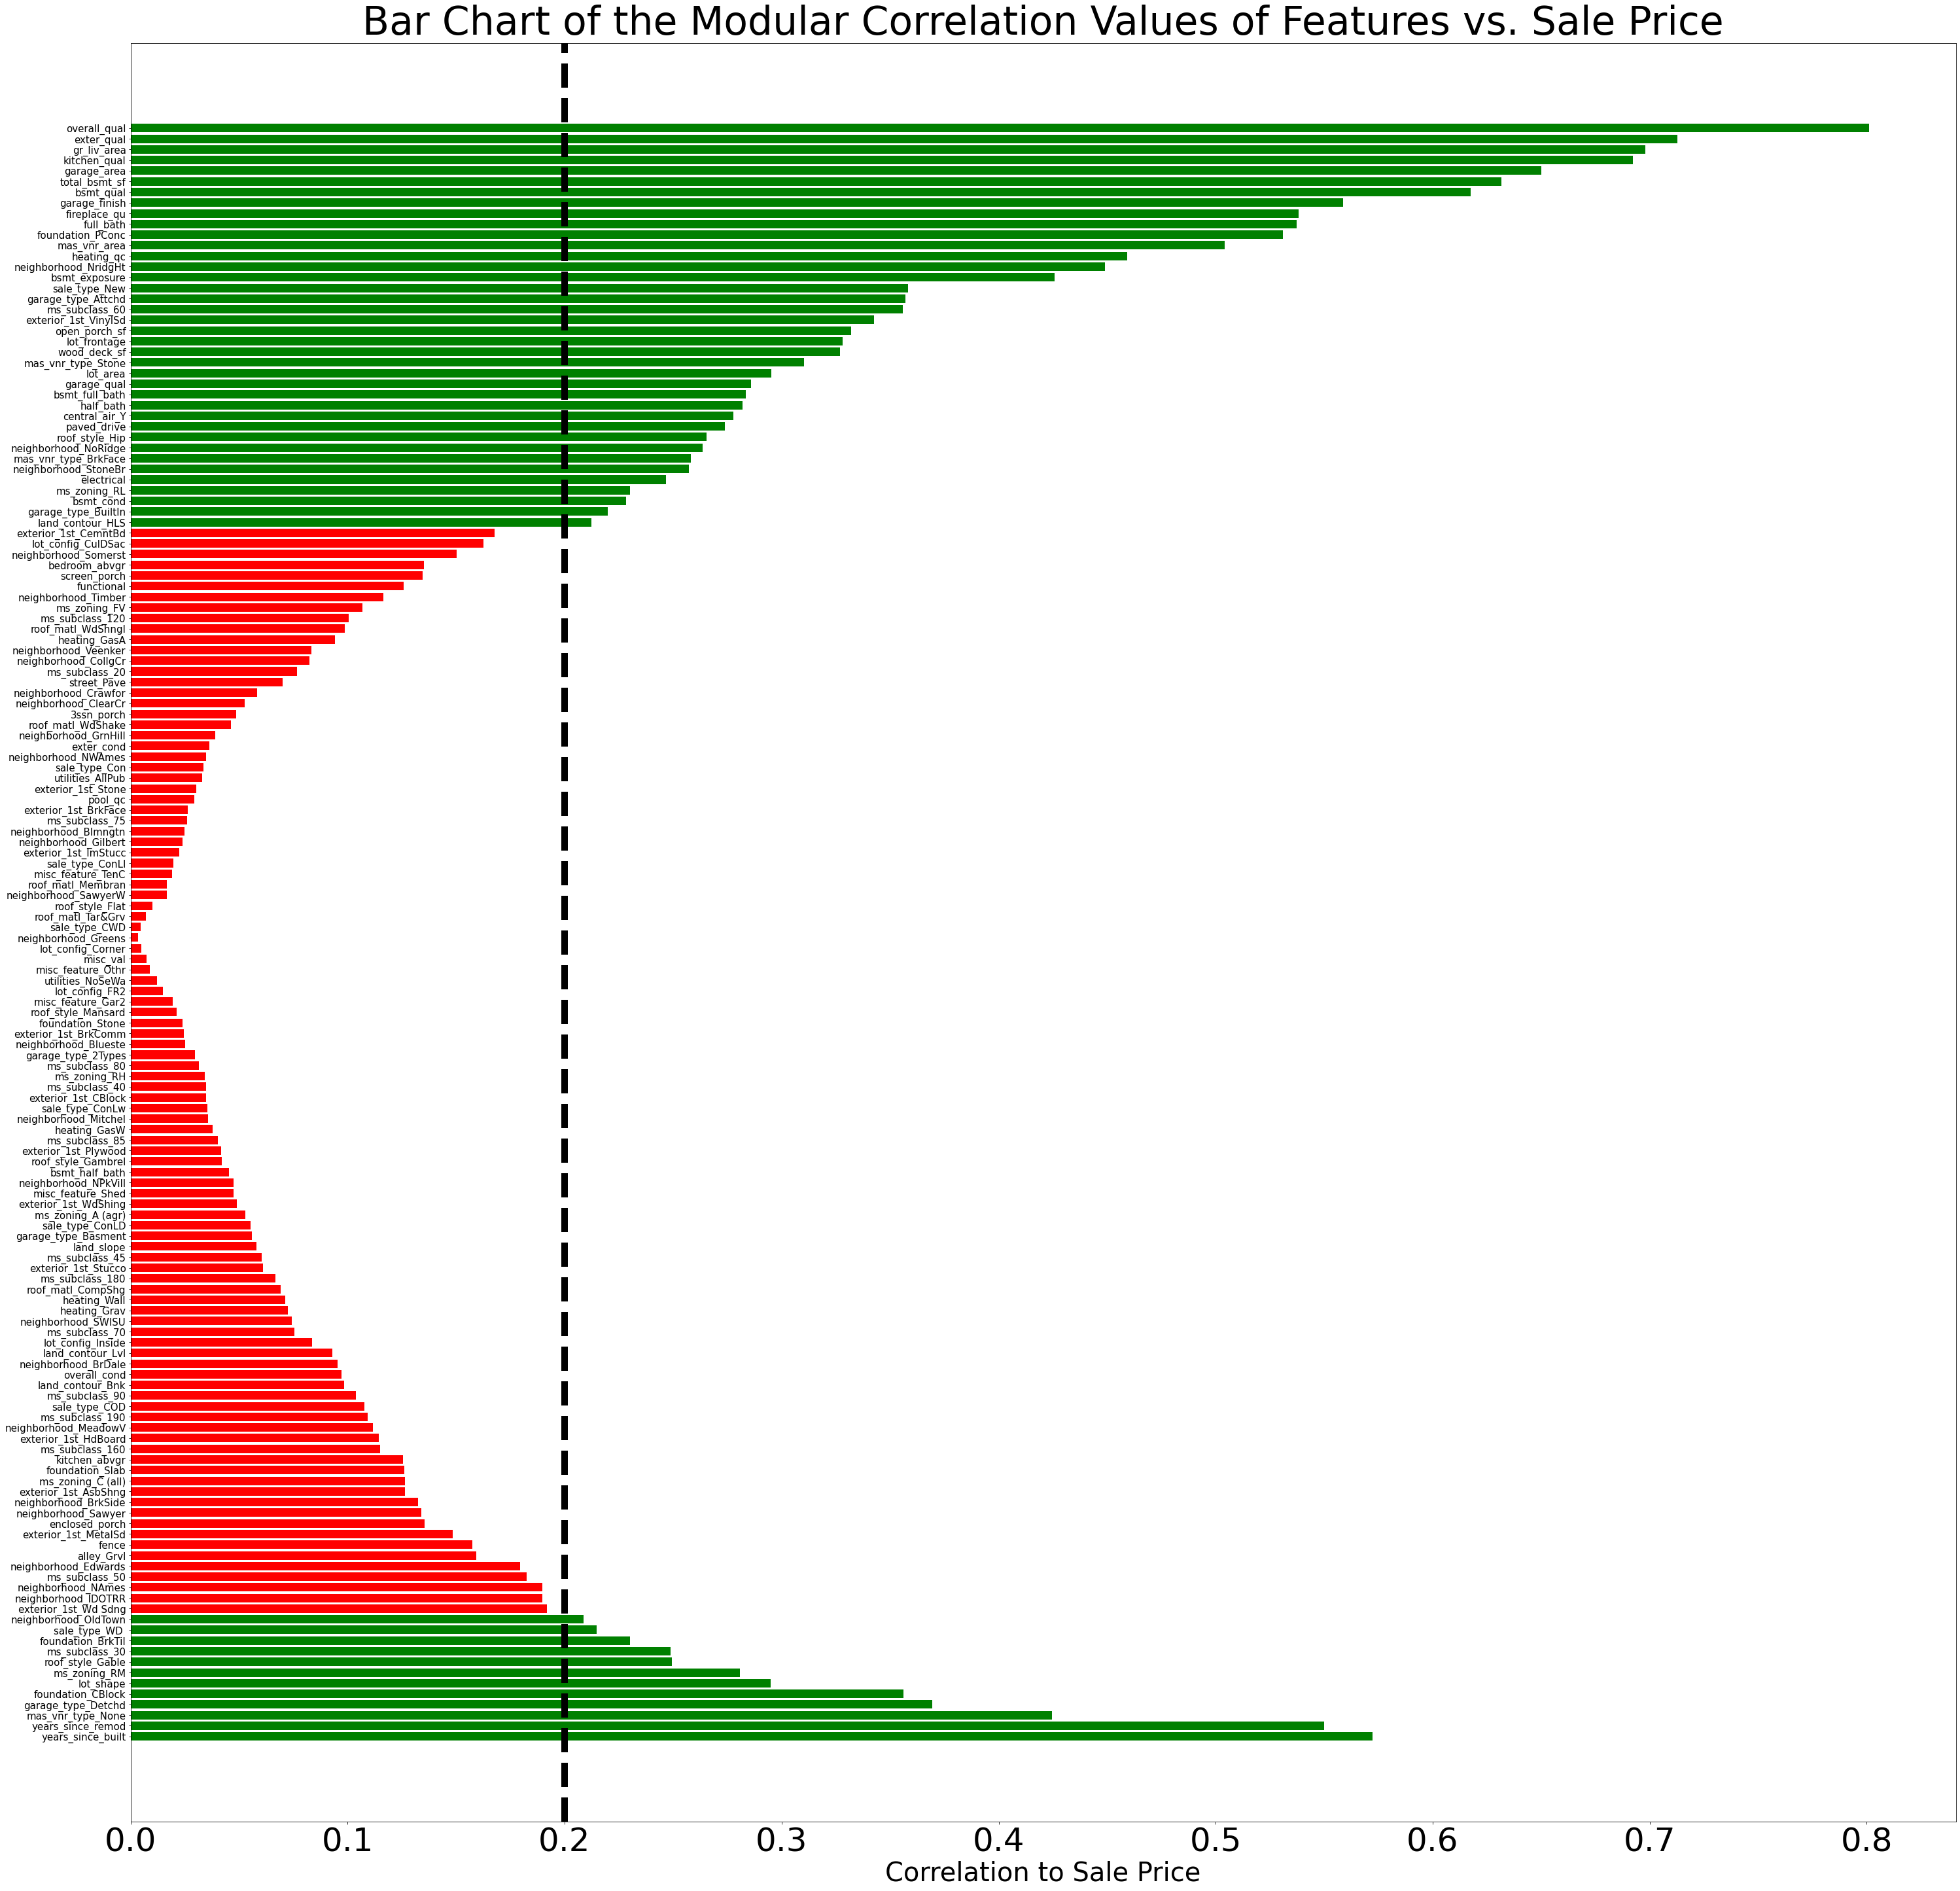

In [26]:
#plotting bar chart of the strength of the correlations of features vs. SalePrice
feature_bar_corr = data_choice.corr()
corr_plot = feature_bar_corr[['saleprice']].sort_values('saleprice')

#plotting bar chart of the strength of the correlations of features vs. SalePrice
x = list(corr_plot.index)
y = corr_plot['saleprice'].map(lambda x: x * -1 if x < 0 else x)
plt.figure(figsize = [50,50])
colormat=np.where((y>0.2), 'g','r')
plt.barh(x[:-1],y[:-1], color = colormat)
plt.title('Bar Chart of the Modular Correlation Values of Features vs. Sale Price', size = 60)
plt.xlabel('Correlation to Sale Price', size = 40)
plt.tick_params(axis='x', labelsize=50)
plt.tick_params(axis='y', labelsize=15)

plt.axvline(x=0.2, ls='--', color = 'black', linewidth = 10)
plt.show()

We see from above that setting an arbitrary threshold as low as 0.2 eliminates a number of features from our model. At this point, what would be the correct threshold to set? Thus, using lasso regression to choose for correlated features might be better for us to eliminate features rather than just setting an arbitrary threshold.

---

## Simple Model

Before moving on to drill down to the best features to use, we will first be setting a baseline model based on the features/specifications required from 99.co.

From the the screenshot above, we find the following features were requested and their closest corresponding feature names from our Ames Housing Dataset:


|99.co|Ames Dataset|Remarks|
|---|---|---|
|Address|Neighborhood|Best indicator of location|
|Property Type|MS Subclass|Best describer of house type|
|Floor Area|Gr Liv Area|Best describer of housing floor area|

In [27]:
#extracting relevant features
model_99co = data_choice.loc[:, [
    'neighborhood_NAmes', 'neighborhood_CollgCr', 'neighborhood_OldTown', 'neighborhood_Edwards',
    'neighborhood_Somerst', 'neighborhood_NridgHt', 'neighborhood_Gilbert', 'neighborhood_Sawyer',
    'neighborhood_NWAmes', 'neighborhood_SawyerW', 'neighborhood_Mitchel', 'neighborhood_BrkSide',
    'neighborhood_Crawfor', 'neighborhood_IDOTRR', 'neighborhood_NoRidge', 'neighborhood_Timber',
    'neighborhood_StoneBr', 'neighborhood_SWISU', 'neighborhood_ClearCr', 'neighborhood_MeadowV',
    'neighborhood_Blmngtn', 'neighborhood_BrDale', 'neighborhood_Veenker', 'neighborhood_NPkVill',
    'neighborhood_Blueste','neighborhood_Greens', 'neighborhood_GrnHill', 'gr_liv_area',
    'ms_subclass_20', 'ms_subclass_60', 'ms_subclass_50', 'ms_subclass_120', 'ms_subclass_30',
    'ms_subclass_70', 'ms_subclass_160', 'ms_subclass_80', 'ms_subclass_90', 'ms_subclass_190',
    'ms_subclass_85', 'ms_subclass_75', 'ms_subclass_180', 'ms_subclass_45', 'ms_subclass_40',
    'saleprice'
]]

In [28]:
#setting X and y
X_99co = model_99co.drop(columns = 'saleprice', axis = 1)
y_99co = model_99co['saleprice']

#doing a train test split

X_train_99co, X_test_99co, y_train_99co, y_test_99co = train_test_split(
    X_99co,
    y_99co,
    test_size = 0.2,
    random_state = 123,
)

#instantiate and fit
lr_99co = LinearRegression()
lr_99co.fit(X_train_99co, y_train_99co)

LinearRegression()

In [29]:
#Scoring the fit
print("\033[4mScoring for model_99co\033[0m");
mse_train_99co = mean_squared_error(y_train_99co, lr_99co.predict(X_train_99co))
print(f"Train MSE: {mse_train_99co}")
mse_test_99co = mean_squared_error(y_test_99co, lr_99co.predict(X_test_99co))
print(f"Test MSE: {mse_test_99co}")

xval_99co = cross_val_score(
    lr_99co,
    X_train_99co,
    y_train_99co,
    cv = 5,
    scoring = 'neg_mean_squared_error',
).mean()
print(f"Cross Val MSE: {(xval_99co * -1)}")

Scoring for model_99co
Train MSE: 1464088294.1777663
Test MSE: 1152320467.0052726
Cross Val MSE: 1576989381.0013125


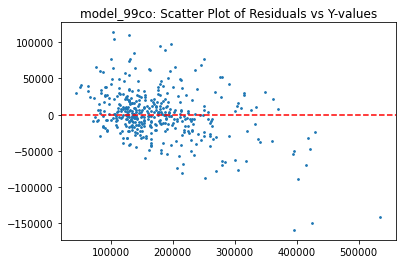

In [30]:
plt.scatter(y_test_99co, (lr_99co.predict(X_test_99co) - y_test_99co), s = 3.0);
plt.axhline(y = 0.5, color = 'r', linestyle = '--');
plt.title('model_99co: Scatter Plot of Residuals vs Y-values');

The scatter plot of residuals vs. that of the Y-values show a general clustering around the x-axis (y=0). However, we do see that there are few points, especially those of higher Sale Prices, have higher residual values. Keeping this and the scores in mind, we now embark to making the model better.

<u>Scoring for model_99co</u>
- Train MSE: 1464088294.1777663
- Test MSE: 1152320467.0052726
- Cross Val MSE: 1576989381.0013125

---

## Pre-processing and Feature Engineering

As discussed above during our Exploratory Data Analysis section, all the features present within the Ames Dataset have a range of correlations to Sale Price. Setting an arbitrary cutoff point may not be the best way in choosing for a better
Thus, doing a Lasso Regression and eliminating those with close to zero coefficient would be a better strategy.

In [31]:
#setting X and y

X = data_choice.drop(columns = 'saleprice', axis = 1)
y = data_choice['saleprice']


#doing a train test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 123,
)


In [32]:
#Standardize prior to Lasso
ss_lasso = StandardScaler()
Z_train = ss_lasso.fit_transform(X_train)
Z_test = ss_lasso.transform(X_test)

#instantiate and fit for LassoCV to find optimum alpha
lasso_cv = LassoCV(
    n_alphas = 500,
    cv = 5,
    max_iter = 1_000,
)

lasso_cv.fit(Z_train, y_train)

LassoCV(cv=5, n_alphas=500)

In [33]:
#extracting the optimum alpha
alpha_lasso_cv = lasso_cv.alpha_

alpha_lasso_cv

874.0802078515503

In [34]:
#Refitting into a Lasso regression

lasso = Lasso(alpha=alpha_lasso_cv)

lasso.fit(Z_train, y_train)

Lasso(alpha=874.0802078515503)

In [35]:
#Scoring
print("\033[4mScoring for Lasso Regression\033[0m");
mse_train_lasso = mean_squared_error(y_train, lasso.predict(Z_train))
mse_test_lasso = mean_squared_error(y_test, lasso.predict(Z_test))

print(f"Train MSE: {mse_train_lasso}")
print(f"Test MSE: {mse_test_lasso}")

xval_lasso = cross_val_score(
    lasso,
    Z_train,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error',
).mean()

print(f"Cross Val MSE: {(xval_lasso * -1)}")

Scoring for Lasso Regression
Train MSE: 701584300.2394094
Test MSE: 649567599.8581142
Cross Val MSE: 1015959823.2855021


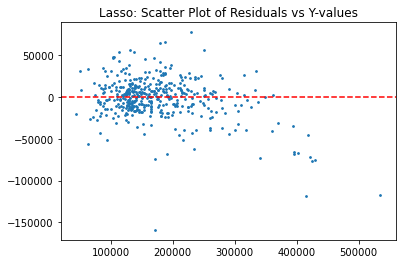

In [36]:
plt.scatter(y_test, (lasso.predict(Z_test) - y_test), s = 3.0);
plt.axhline(y = 0.5, color = 'r', linestyle = '--');
plt.title('Lasso: Scatter Plot of Residuals vs Y-values');

In [37]:
print("\033[4m% Improvement of Lasso over the Base 99co model\033[0m");
print(f"Train MSE: {100-(mse_train_lasso/mse_train_99co * 100)}%")
print(f"Test MSE: {100-(mse_test_lasso/mse_test_99co * 100)}%")
print(f"Cross Val MSE: {100-(xval_lasso/xval_99co * 100)}%")

% Improvement of Lasso over the Base 99co model
Train MSE: 52.08046515846095%
Test MSE: 43.629604918304196%
Cross Val MSE: 35.57598830244396%


From here we see that with our Lasso Regression we have improved on our model scores across the board. We can also see that the spread of our residuals are also narrower along the x-axis (y = 0). This means that the base 99co model is not good to predict unseen data as much as our new Lasso model. That being said, the current model is still far from being a finished ready to ship production model. 

First, we'll take a look at the coefficients identified for our features.

In [38]:
#extracting the lasso coefficients and matching it to the features
lasso_coef = pd.DataFrame(lasso.coef_, index = X.columns, columns = ['lasso_coef'])
pd.set_option('display.max_rows', None)
lasso_coef.sort_values('lasso_coef')

#adding sale price corr to the df
corr_coef = pd.merge(
    left = lasso_coef,
    right = corr_plot,
    left_index=True,
    right_index=True
)

corr_coef.head()

,lasso_coef,saleprice
lot_frontage,-0.000000,0.328149
lot_area,2132.802267,0.295121
mas_vnr_area,4077.683840,0.504025
total_bsmt_sf,491.902174,0.631507
gr_liv_area,24273.462134,0.698046


From the coefficient values, we see that Lasso has identified numerous features (including dummies) as zero (or very close to it). These features are very likely those that had low correlation scores against Sale Price in the first place, compared to others.

However, we do see that there are some coef values which are zero but have a substantial correlation to Sale Price. This is most likely a case of collinearity whereby a stronger collinear feature (like gr_liv_area) is chosen over, for example, lot_frontage.

**Pairwise Collinearity of lot_frontage vs. gr_liv_area:** 0.360696

|Feature|lasso_coef Value|Saleprice Correlation|
|---|---|---|
|lot_frontage|-0.000000|0.328149|
|gr_liv_area|24273.462134|0.698046|


---

## Model Benchmarks and Tuning

### Linear Regression Model after dropping Zero Coefficient Features

First, we remove the features that has zero coefficients from lasso regression. and then plot a Linear regression to check the performance.


In [39]:
#identify the features with close to zero coef

mask_0_coef = ((lasso_coef < 0.01) & (lasso_coef > -0.01))
sorted_0_coef = lasso_coef[mask_0_coef].sort_values('lasso_coef')
feature_0_coef = list(sorted_0_coef[sorted_0_coef['lasso_coef'].between(0,98)].index)

In [40]:
#removing it from data_choice

data_drop_0 = data_choice.drop(columns = feature_0_coef, axis = 1)

In [41]:
#setting X and y
X_drop_0 = data_drop_0.drop(columns = 'saleprice', axis = 1)
y_drop_0 = data_drop_0['saleprice']

#doing a train test split

X_train_drop_0, X_test_drop_0, y_train_drop_0, y_test_drop_0 = train_test_split(
    X_drop_0,
    y_drop_0,
    test_size = 0.2,
    random_state = 123,
)

#instantiate and fit
lr_drop_0 = LinearRegression()
lr_drop_0.fit(X_train_drop_0, y_train_drop_0)

LinearRegression()

In [42]:
#Scoring the fit
print("\033[4mScoring for LR drop_0\033[0m");
mse_train_lr_drop_0 = mean_squared_error(y_train_drop_0, lr_drop_0.predict(X_train_drop_0))
mse_test_lr_drop_0 = mean_squared_error(y_test_drop_0, lr_drop_0.predict(X_test_drop_0))
print(f"Train MSE: {mse_train_lr_drop_0}")
print(f"Test MSE: {mse_test_lr_drop_0}")

xval_drop_0 = cross_val_score(
    lr_drop_0,
    X_train_drop_0,
    y_train_drop_0,
    cv = 5,
    scoring = 'neg_mean_squared_error',
).mean()
print(f"Cross Val MSE: {(xval_drop_0 * -1)}")

Scoring for LR drop_0
Train MSE: 651192793.1437973
Test MSE: 666638781.0913363
Cross Val MSE: 1022462959.6851747


In [43]:
print("\033[4m% Improvement of drop_0 Linear Regression over the Lasso model\033[0m");
print(f"Train MSE: {100-(mse_train_lr_drop_0/mse_train_lasso * 100)}%")
print(f"Test MSE: {100-(mse_test_lr_drop_0/mse_test_lasso * 100)}%")
print(f"Cross Val MSE: {100-(xval_drop_0/xval_lasso * 100)}%")

% Improvement of drop_0 Linear Regression over the Lasso model
Train MSE: 7.182530606573792%
Test MSE: -2.6280838571614282%
Cross Val MSE: -0.6400977923164675%


As expected, there is not much improvement over lasso scores because the same number of features were used. Now, we will be exploring regularization to introduce more bias and see if we can improve the scores further.

### Ridge Regression

In [44]:
#Standardize
ss_drop_0 = StandardScaler()
Z_train_drop_0 = ss_drop_0.fit_transform(X_train_drop_0)
Z_test_drop_0 = ss_drop_0.transform(X_test_drop_0)

#Perform RidgeCV to get the best Ridge alpha.

#setting alpha range
r_alphas = np.logspace(0, 5, 100)

#instantiate RidgeCV
ridge_cv = RidgeCV(
    alphas = r_alphas,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)

#fit RidgeCV to obtain best alpha
ridge_cv.fit(Z_train_drop_0, y_train_drop_0);

In [45]:
#retrieving alpha value
alpha_ridge = ridge_cv.alpha_

In [46]:
#refitting the best ridge alpha into a RidgeRegression
ridge = Ridge(alpha=alpha_ridge)

ridge.fit(Z_train_drop_0, y_train_drop_0)

Ridge(alpha=335.1602650938841)

In [47]:
print("\033[4mScoring for Ridge Regression for drop_0 data\033[0m");
mse_train_ridge = mean_squared_error(y_train_drop_0, ridge.predict(Z_train_drop_0))
mse_test_ridge = mean_squared_error(y_test_drop_0, ridge.predict(Z_test_drop_0))
print(f"Train MSE: {mse_train_ridge}")
print(f"Test MSE: {mse_test_ridge}")

xval_ridge = cross_val_score(
    ridge,
    Z_train_drop_0,
    y_train_drop_0,
    cv = 5,
    scoring = 'neg_mean_squared_error',
).mean()

print(f"Cross Val MSE: {(xval_ridge * -1)}")

Scoring for Ridge Regression for drop_0 data
Train MSE: 702796769.9508892
Test MSE: 619778333.4584917
Cross Val MSE: 950438300.0537418


In [48]:
print("\033[4m% Improvement of drop_0 Ridge Regression over the Linear Regression model\033[0m");
print(f"Train MSE: {100-(mse_train_ridge/mse_train_lr_drop_0 * 100)}%")
print(f"Test MSE: {100-(mse_test_ridge/mse_test_lr_drop_0 * 100)}%")
print(f"Cross Val MSE: {100-(xval_ridge/xval_drop_0 * 100)}%")

% Improvement of drop_0 Ridge Regression over the Linear Regression model
Train MSE: -7.9245313139847156%
Test MSE: 7.029361171597387%
Cross Val MSE: 7.044231671102281%


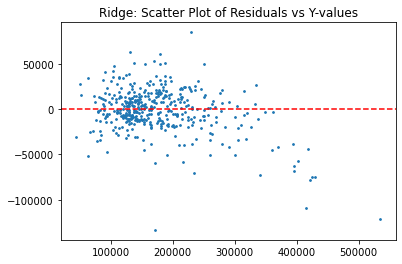

In [49]:
plt.scatter(y_test_drop_0, (ridge.predict(Z_test_drop_0) - y_test_drop_0), s = 3.0);
plt.axhline(y = 0.5, color = 'r', linestyle = '--');
plt.title('Ridge: Scatter Plot of Residuals vs Y-values');

We see that the Ridge regression model performed worse than the linear regression model in terms of Train MSE but improved in both Test MSE and Cross Val MSE. This means we have effective introduced more bias in order to better predict future unseen data.

---

## Production Model

Comparing the scores across all models done we see that the Ridge Regression model after dropping Lasso zero coefficient features performed the best. and hence this will be the model that we set as the production model.

|Model|Train MSE|Test MSE|Cross Val Score|
|---|---|---|---|
|drop_0_coeff Ridge Regression|702796769|619778333|950438300|
|drop_0_coeff Linear Regression|651192793|666638781|1022462959|
|Lasso Regression|701584300|649567599|1015959823|
|99co Linear Regression|1464088294|1152320467|1576989381|

In [50]:
950438300/1576989381
1- 950438300/1576989381

0.39730837033454947

In [51]:
#training the whole train dataset (train + holdout)
data_prod = data_drop_0.loc[:,:]

X_prod = data_prod.drop(columns = 'saleprice', axis = 1)
y_prod = data_prod['saleprice']

ss_prod = StandardScaler()
Z_prod = ss_prod.fit_transform(X_prod)

ridge_cv_prod = RidgeCV(
    alphas = r_alphas,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)

ridge_cv_prod.fit(Z_prod, y_prod);

In [52]:
alpha_ridge = ridge_cv.alpha_
ridge_prod = Ridge(alpha=alpha_ridge)

ridge_prod.fit(Z_prod, y_prod)

Ridge(alpha=335.1602650938841)

In [53]:
print("\033[4mProduction Model Attributes\033[0m");
mse_prod = mean_squared_error(y_prod, ridge_prod.predict(Z_prod))
print(f"Train MSE: {mse_prod}")

xval_prod = cross_val_score(
    ridge_prod,
    Z_prod,
    y_prod,
    cv = 5,
    scoring = 'neg_mean_squared_error',
).mean()

print(f"Cross Val MSE: {(xval_prod * -1)}")
print(f"Ridge Regression Alpha: {alpha_ridge}")
print(f"Total Features Used: {data_prod.shape[1] - 1}")

Production Model Attributes
Train MSE: 673341543.1264241
Cross Val MSE: 833273475.817483
Ridge Regression Alpha: 335.1602650938841
Total Features Used: 73


---

## Insights

### Production Model Summary

From fitting our best model on the whole dataset available to us, we see that the cross validation MSE is still far from the Train MSE. This is indicative of an overfit model which is not biased enough to effectively handle unseen data. What else can be explored but was not in this project was to reduce overfitting by the following measures:

1) Eliminating outliers from deep-diving into model predicted residuals.

2) Explore pairwise interactions.

3) Explore different cutoffs to see which will effectively eliminate poorly correlated features (vs. Target) and produce the best model.



### Project Insights

Although we have identified relevant features for our model through machine learning and feature engineering, at the end of the day we have 73 features in our model and some of the features used in our model are not reasonable real estate knowledge that our day-to-day homeowners might have. If we were to roll out our model as is and requesting that many difficult inputs, people using our platform might find it daunting, which begets the purpose of creating this in the first place.

Thus, it might be more prudent to work with our real estate agents to get an idea of what data or which features are easily known/accessible by our homeowners. Through this, we can have a platform that is not only accurate, but easy to use too. In a way, we want to strike the balance between the simplicity offered by 99co vs our model accuracy and hence, more work can be done to bring this up to be production-ready.



---

## Kaggle Submission Score

In [54]:
#exporting dataset
data_prod.to_csv('datasets/data_prod.csv', index=False)

Score of Production Model:

Score: 24052.28611

Public score: 33203.03021